Для начала введем константы для работы с нашим датасетом

In [1]:
from pandas import DataFrame

DATASET_PATH = r"C:\Users\geize\Downloads\data\extracted_images"

In [2]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from typing import List, Any
import sklearn.metrics as mk

Проверим доступные нам папки в датасете

In [3]:
print(os.listdir(DATASET_PATH))

['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'alpha', 'ascii_124', 'b', 'beta', 'C', 'cos', 'd', 'Delta', 'div', 'e', 'exists', 'f', 'forall', 'forward_slash', 'G', 'gamma', 'geq', 'gt', 'H', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'M', 'mu', 'N', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'prime', 'q', 'R', 'rightarrow', 'S', 'sigma', 'sin', 'sqrt', 'sum', 'T', 'tan', 'theta', 'times', 'u', 'v', 'w', 'X', 'y', 'z', '[', ']', '{', '}']


Нам понадобиться методы для работы с датасетом

In [3]:
def get_dataset_directories() -> list[str]:
    return os.listdir(DATASET_PATH)

In [5]:
def load_and_preprocess_image(image_path):    
    image = cv2.imread(image_path)
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return gray_image.flatten()

In [5]:
def get_dataset_without_flatten():
    X, Y = [], []
        
    for dir_name in get_dataset_directories():
        dir = os.listdir(DATASET_PATH + f"/{dir_name}")
        
        for file in dir:
            path = os.path.join(DATASET_PATH, dir_name, file)
            X.append(cv2.imread(str(path)))
            Y.append(dir_name)
    
    return X, Y

In [6]:
def get_dataset():
    X, Y = [], []
        
    for dir_name in get_dataset_directories():
        dir = os.listdir(DATASET_PATH + f"/{dir_name}")
        
        for file in dir:
            path = os.path.join(DATASET_PATH, dir_name, file)
            X.append(load_and_preprocess_image(str(path)))
            Y.append(dir_name)
    
    return X, Y

In [3]:
def reduce_samples_per_class(df, label_column, max_samples_per_class=2000):
    grouped = df.groupby(label_column)
    
    reduced_df = pd.DataFrame()
    
    for name, group in grouped:
        if len(group) > max_samples_per_class:
            group = group.sample(n=max_samples_per_class, random_state=42)
        reduced_df = pd.concat([reduced_df, group])
    
    return reduced_df

In [4]:
def save_images_dataset_to_csv_file(X, y, filename = 'dataset'):
    pixel_columns = [f"pixel_{i+1}" for i in range(len(X[0]))]
    df_pixels = pd.DataFrame(X, columns=pixel_columns)
    
    df_pixels['label'] = y
    
    df_pixels.to_csv(
        f"{filename}.csv",
        index=False
    )
    
    return df_pixels

In [5]:
def read_X_and_y_from_csv(path):
    df = pd.read_csv(path)

    X = df.drop(columns=['label']).to_numpy()
    y = df['label'].to_numpy().astype(str)
    
    return X, y

In [6]:
def reduce_number_of_feature_in_dataset(X, y, custom_n_components = -1):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    joblib.dump(scaler, 'scaler_2000_pca.pkl')
    
    pca = PCA()
    pca.fit(X_scaled)
    
    # Вывод доли объяснённой дисперсии
    explained_variance = pca.explained_variance_ratio_
    print("Доля объяснённой дисперсии:", explained_variance)
    
    # Нахождение минимального числа компонент для 95% дисперсии
    cum_sum = np.cumsum(explained_variance)
    n_components = np.argmax(cum_sum >= 0.95) + 1  # +1, потому что индексация с 0
    print(f"Для 95% дисперсии достаточно {n_components} компонент.")
    
    if custom_n_components >= 0:
        n_components = custom_n_components
        print(f"Используется {n_components} компонент по параметру custom_n_components.")

    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X_scaled)
    
    df_reduced = pd.DataFrame(X_reduced, columns=[f'PC{i+1}' for i in range(n_components)])
    df_reduced['label'] = y
    
    joblib.dump(pca, 'pca_model_2000.pkl')
    
    return df_reduced, pca

In [8]:
def get_replaced_negatives_with_zero_dataset(X, y):
    X = np.clip(X, a_min=0, a_max=None)
    df = pd.DataFrame(X)
    df['label'] = y
    
    return df

In [9]:
def get_class_weights_by_targets(targets):
    classes = get_classes(targets)

    class_weights = compute_class_weight('balanced', classes=classes, y=targets)
    class_weights_dict = dict(zip(classes, class_weights))
    
    return class_weights_dict

In [10]:
def get_classes(targets):
    return np.unique(targets)

In [11]:
def plot_gallery(images, titles, h, w, n_row = 3, n_col = 4):
    plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray)
        plt.title(titles[i], size = 12)
        plt.xticks(())
        plt.yticks(())

Сохраняем обработанные данные о фото в csv файл

In [38]:
X, y = get_dataset()

save_images_dataset_to_csv_file(X, y, 'dataset_very_small_min_max_scaller.csv').head()

,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,...,pixel_2017,pixel_2018,pixel_2019,pixel_2020,pixel_2021,pixel_2022,pixel_2023,pixel_2024,pixel_2025,label
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
1,255,255,255,255,255,255,255,255,255,255,...,254,255,252,255,255,255,255,255,255,0
2,255,255,254,255,255,253,255,253,254,255,...,249,255,251,255,255,255,255,255,255,0
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
4,254,255,254,255,255,255,252,255,255,254,...,255,255,255,255,255,255,255,255,255,0


Загрузим датасет из полученного csv файла

In [12]:
df = pd.read_csv('dataset.csv')

X = df.drop(columns=['label']).to_numpy()
y = df['label'].to_numpy().astype(str)

X

C:\Users\geize\AppData\Local\Temp\ipykernel_60312\3290691412.py:1: DtypeWarning: Columns (2025) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset.csv')


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

Срезаем наш датасет до приемлемых значений:

In [13]:
reduced_df = reduce_samples_per_class(df, 'label', 2000)

X_reduced = reduced_df.drop(columns=['label']).to_numpy()
y_reduced = reduced_df['label'].to_numpy().astype(str)

In [12]:
X_reduced

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 254, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

Посмотрим на то, как выглядят картинки после обраотки в датасете

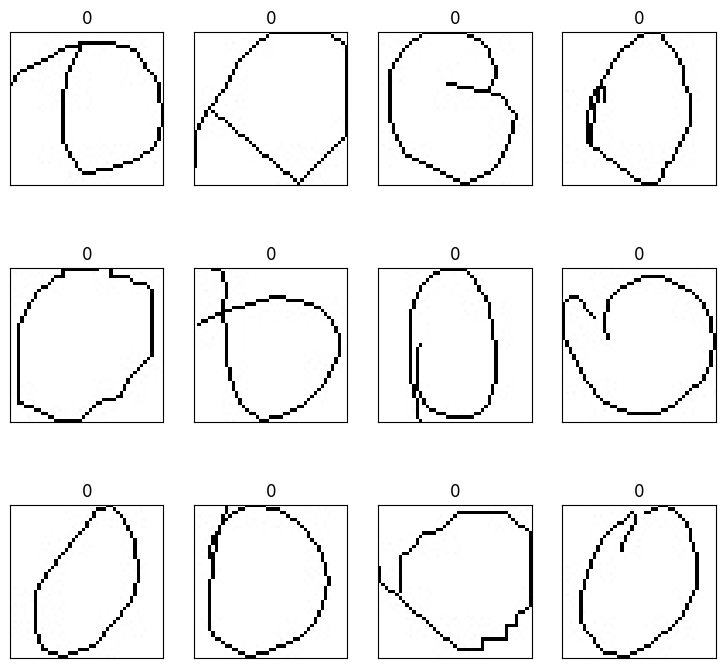

In [15]:
h, w = 45, 45 

plot_gallery(X_reduced[0:12], y_reduced[0:12], h, w)


Сократим количество признаков, используя метод PCA

In [14]:
pca_reduced_df, pca = reduce_number_of_feature_in_dataset(X_reduced, y_reduced)

X_reduced_pca = pca_reduced_df.drop(columns=['label']).to_numpy()
y_reduced_pca = pca_reduced_df['label'].to_numpy().astype(str)

Доля объяснённой дисперсии: [1.66885824e-02 1.11162120e-02 8.58910677e-03 ... 5.32980964e-05
 4.88650692e-05 4.43212896e-05]
Для 95% дисперсии достаточно 1661 компонент.


смотрим итоговый датасет

In [17]:
X_reduced_pca

array([[-5.25453027, -0.56959565,  6.34480516, ..., -0.14675405,
         0.2287505 , -0.63190703],
       [-9.99549625, -4.63373115,  6.61316576, ..., -0.74140399,
         0.12186804, -0.24006937],
       [-4.00933086, -7.28373809, -2.34313863, ..., -0.88686957,
         0.63720806,  0.6578076 ],
       ...,
       [ 5.07896734,  4.929835  ,  2.38631735, ..., -0.05472067,
         0.27151373, -0.68199373],
       [ 4.39151794,  5.75666309,  2.88870052, ..., -1.01339766,
         0.1612731 ,  0.29389006],
       [ 4.2440353 ,  5.54914639,  1.97654683, ...,  0.45101743,
         0.07251673,  0.36186793]])

Смотрим картинки после сжатия

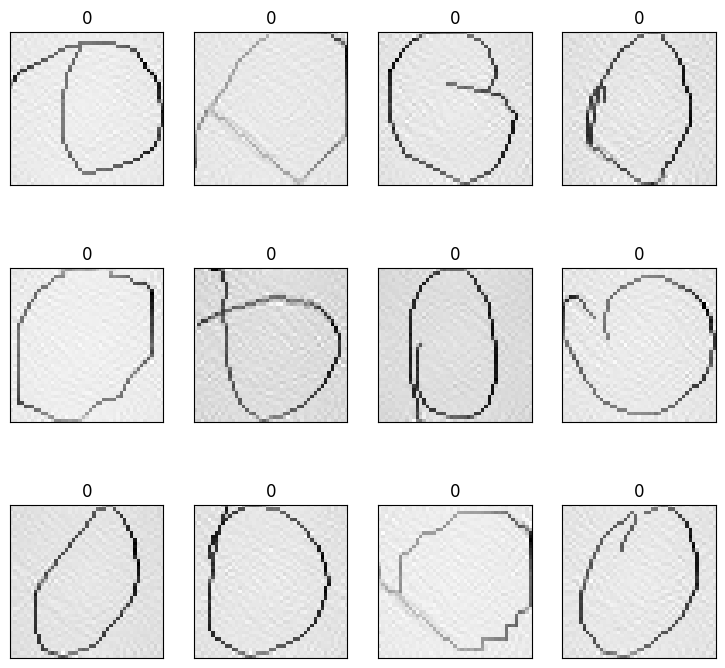

In [18]:
h, w = 45, 45 

X_reconstructed = pca.inverse_transform(X_reduced_pca)

plot_gallery(X_reconstructed[0:12], y_reduced_pca[0:12], h, w)

Необходимо понять как выглядит распределение меток в датасете

Распределение меток:
label
0         5172
1         5000
2         5000
3         5000
4         5000
          ... 
Delta      137
lambda     109
in          47
forall      45
exists      21
Name: count, Length: 82, dtype: int64


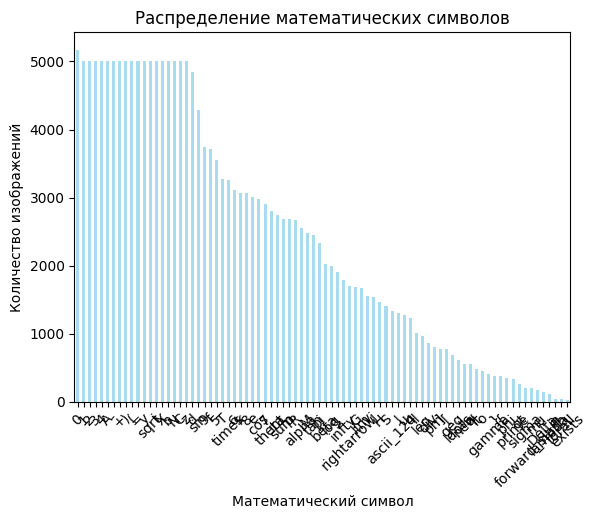

In [19]:
label_counts = pca_reduced_df['label'].value_counts()

print("Распределение меток:")
print(label_counts)

label_counts.plot(kind='bar', alpha=0.7, color='skyblue')
plt.title("Распределение математических символов")
plt.xlabel("Математический символ")
plt.ylabel("Количество изображений")
plt.xticks(rotation=45)
plt.show()

Проверим есть ли пустые метки в датасете:

In [20]:
print("Распределение меток:")
print(label_counts.to_dict())

print("Пустых меток:")
print(df['label'].isnull().sum())


Распределение меток:
{'0': 5172, '1': 5000, '2': 5000, '3': 5000, '4': 5000, 'A': 5000, '-': 5000, '+': 5000, ')': 5000, '(': 5000, '=': 5000, 'y': 5000, 'sqrt': 5000, 'i': 5000, 'X': 5000, 'b': 5000, 'N': 5000, 'C': 5000, 'z': 5000, 'd': 4852, 'sin': 4293, '9': 3737, 'f': 3712, '5': 3545, 'T': 3274, 'times': 3251, '6': 3118, 'k': 3074, '8': 3068, 'e': 3003, 'cos': 2986, '7': 2909, 'theta': 2796, 'int': 2742, 'sum': 2689, 'p': 2680, 'R': 2671, 'alpha': 2546, 'M': 2476, 'tan': 2450, 'pi': 2332, 'beta': 2025, 'log': 2001, ',': 1906, 'infty': 1783, 'rightarrow': 1703, 'G': 1692, 'lim': 1675, 'v': 1558, 'j': 1536, 'H': 1464, 'S': 1413, 'ascii_124': 1339, '!': 1300, 'u': 1269, 'q': 1230, 'l': 1017, 'leq': 973, 'div': 868, 'pm': 802, ']': 780, '[': 778, 'geq': 693, 'ldots': 609, 'neq': 558, 'w': 556, 'lt': 477, 'o': 449, 'gamma': 409, '}': 377, '{': 376, 'phi': 355, 'prime': 329, 'gt': 258, 'sigma': 201, 'forward_slash': 199, 'mu': 177, 'Delta': 137, 'lambda': 109, 'in': 47, 'forall': 45, 'e

Нам повезло и наш датасет не содержит пустых меток, однако, как мы видим, распределение классов в датасете совсем не сбалансированно, что будет крайне плохо в нашем случае, когда мы собираемся использовать Наивного Байоса.

In [8]:
y

array(['0', '0', '0', ..., '}', '}', '}'], shape=(118029,), dtype='<U13')

Для того, чтобы преставить категориальные таргеты как числовые мы прибегнем к способу one_hot_encoding

In [7]:
encoder = OneHotEncoder(sparse_output=False)

y_encoded = encoder.fit_transform(y.reshape(-1, 1))

print("Исходные символы:")
print(y)
print("\nOne-hot encoded символы:")
print(y_encoded)

df_encoded = pd.DataFrame(y_encoded, columns=encoder.get_feature_names_out())
df_encoded['Symbol'] = y

print("\nDataFrame с символами и их one-hot кодами:")
print(df_encoded)
print(y_encoded)

Исходные символы:
['!' '!' '!' ... '}' '}' '}']

One-hot encoded символы:
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]

DataFrame с символами и их one-hot кодами:
        x0_!  x0_(  x0_)  x0_+  x0_,  x0_-  x0_0  x0_1  x0_2  x0_3  ...  \
0        1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1        1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2        1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3        1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4        1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
375969   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
375970   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
375971   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

Разобьем датасет на обучающую и тестовую выборки

In [27]:
replaced_negatives_with_zero_dataset = get_replaced_negatives_with_zero_dataset(
    X_reduced_pca,
    y_reduced_pca
)

X_replaced_negatives_with_zero = replaced_negatives_with_zero_dataset.drop(columns=['label']).to_numpy()
y_replaced_negatives_with_zero = replaced_negatives_with_zero_dataset['label'].to_numpy().astype(str)

посмотрим

In [28]:
X_replaced_negatives_with_zero

array([[0.        , 0.        , 0.        , ..., 0.4039026 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.28673219],
       [0.        , 0.        , 1.56756679, ..., 0.        , 0.        ,
        0.07436982],
       ...,
       [5.10479877, 5.25815221, 0.        , ..., 0.        , 0.01018299,
        0.        ],
       [4.44565715, 5.97153098, 0.        , ..., 0.03608443, 0.0594341 ,
        0.        ],
       [4.17349756, 5.79505753, 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(118029, 1661))

Посмотрим на сколько картинки испортились

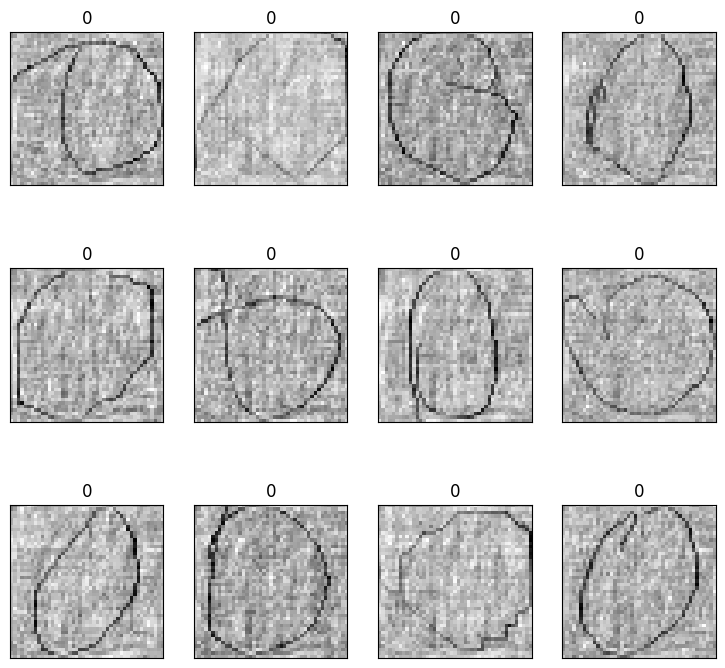

In [30]:
h, w = 45, 45 

X_reconstructed = pca.inverse_transform(X_replaced_negatives_with_zero)

plot_gallery(X_reconstructed[0:12], y_replaced_negatives_with_zero[0:12], h, w)

Мы можем воспользоваться весами, чтобы класс, которого меньше всего по важности был равен тому, которого больше всего

In [34]:
class_weights_dict = get_class_weights_by_targets(y_replaced_negatives_with_zero)

class_weights_dict

{np.str_('!'): np.float64(1.1072138836772982),
 np.str_('('): np.float64(0.7196890243902438),
 np.str_(')'): np.float64(0.7196890243902438),
 np.str_('+'): np.float64(0.7196890243902438),
 np.str_(','): np.float64(0.7551826069152612),
 np.str_('-'): np.float64(0.7196890243902438),
 np.str_('0'): np.float64(0.6626970758657863),
 np.str_('1'): np.float64(0.7196890243902438),
 np.str_('2'): np.float64(0.7196890243902438),
 np.str_('3'): np.float64(0.7196890243902438),
 np.str_('4'): np.float64(0.7196890243902438),
 np.str_('5'): np.float64(0.7196890243902438),
 np.str_('6'): np.float64(0.7196890243902438),
 np.str_('7'): np.float64(0.7196890243902438),
 np.str_('8'): np.float64(0.7196890243902438),
 np.str_('9'): np.float64(0.6025023226372909),
 np.str_('='): np.float64(0.7196890243902438),
 np.str_('A'): np.float64(0.7196890243902438),
 np.str_('C'): np.float64(0.7196890243902438),
 np.str_('Delta'): np.float64(10.506409115186042),
 np.str_('G'): np.float64(0.8506962463241654),
 np.str_(

In [31]:
X_nb_train, X_nb_test, y_nb_train, y_nb_test = train_test_split(
    X_replaced_negatives_with_zero,
    y_replaced_negatives_with_zero,
    test_size=0.2,
    random_state=42,
    stratify=y_replaced_negatives_with_zero
)

Можем попробовать обучить модель на исходных данных с такими весами

In [35]:
class_prior = np.array([class_weights_dict[cls] for cls in get_classes(y_replaced_negatives_with_zero)])

class_prior = class_prior / np.sum(class_prior)

print(class_prior)

[0.00407544 0.00264903 0.00264903 0.00264903 0.00277968 0.00264903
 0.00243926 0.00264903 0.00264903 0.00264903 0.00264903 0.00264903
 0.00264903 0.00264903 0.00264903 0.00221769 0.00264903 0.00264903
 0.00264903 0.03867202 0.00313125 0.0036189  0.00264903 0.00264903
 0.00264903 0.00374952 0.00264903 0.00264903 0.00680986 0.00679239
 0.00264903 0.00395673 0.00264903 0.00264903 0.00264903 0.00264903
 0.00610376 0.00264903 0.25228892 0.00264903 0.11773483 0.02662345
 0.01295371 0.00764512 0.02053514 0.00264903 0.11272484 0.00297143
 0.00264903 0.00344926 0.00264903 0.00520951 0.04860612 0.00869962
 0.00544508 0.00316303 0.00264903 0.01110706 0.02993258 0.00949474
 0.0117997  0.00264903 0.01492413 0.00264903 0.00660607 0.01610355
 0.00430737 0.00311102 0.02635854 0.00264903 0.00264903 0.00264903
 0.00264903 0.00264903 0.00264903 0.00417499 0.00340056 0.0095289
 0.00264903 0.00264903 0.0140906  0.01405323]


In [48]:
# model = MultinomialNB(class_prior=class_prior)
model = MultinomialNB()
model.fit(X_nb_train, y_nb_train)

MultinomialNB()

Оценим полученую модель на выбранных для данного проекта метриках

In [49]:
y_pred = model.predict(X_nb_test)

precision_macro = precision_score(y_nb_test, y_pred, average='macro')
recall_macro = recall_score(y_nb_test, y_pred, average='macro')
f1_macro = f1_score(y_nb_test, y_pred, average='macro')

print(f"Макро-усредненный Precision: {precision_macro:.4f}")
print(f"Макро-усредненный Recall: {recall_macro:.4f}")
print(f"Макро-усредненный F1: {f1_macro:.4f}")

Макро-усредненный Precision: 0.5989
Макро-усредненный Recall: 0.6119
Макро-усредненный F1: 0.5948


Посмотрим на матрицу ошибок модели:

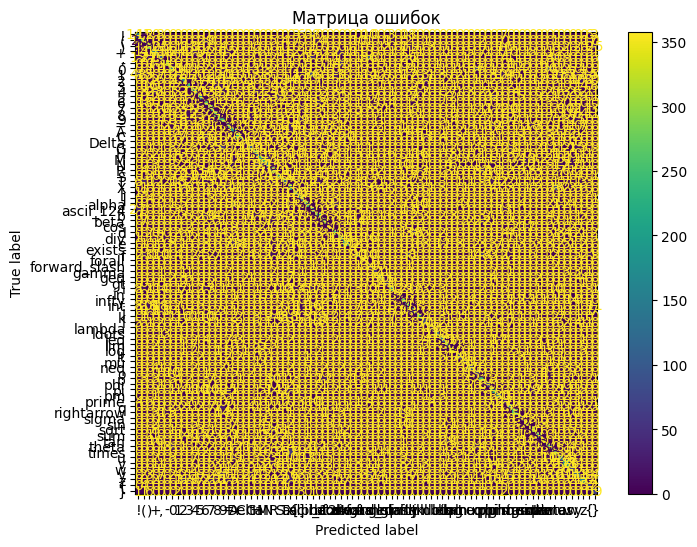

In [46]:
cm = confusion_matrix(y_nb_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_nb_test))
disp.plot(ax=ax)

plt.title("Матрица ошибок")
plt.show()

Сохраним веса обученной модели

In [47]:
joblib.dump(model, 'multinomial_nb_2000_model_with_weight.pkl')

print("Модель сохранена в файл 'multinomial_nb_model.pkl'")

Модель сохранена в файл 'multinomial_nb_model.pkl'


Наивный Байос дяже при учете всех обработок нашего датасета не дал хорошей оценки. Попробуем восопользоваться методом опорных векторов:


In [50]:
X_svm_train, X_svm_test, y_svm_train, y_svm_test = train_test_split(
    X_reduced_pca,
    y_reduced_pca,
    test_size=0.2,
    random_state=42,
    stratify=y_reduced_pca
)

In [52]:
model_svm = LinearSVC(random_state=42)

model_svm.fit(X_svm_train, y_svm_train)

C:\Users\geize\PycharmProjects\snap-math\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=42)

Оценим полученную модель:

In [54]:
y_pred = model_svm.predict(X_svm_test)

precision_macro = precision_score(y_svm_test, y_pred, average='macro')
recall_macro = recall_score(y_svm_test, y_pred, average='macro')
f1_macro = f1_score(y_svm_test, y_pred, average='macro')

print(f"Макро-усредненный Precision: {precision_macro:.4f}")
print(f"Макро-усредненный Recall: {recall_macro:.4f}")
print(f"Макро-усредненный F1: {f1_macro:.4f}")

Макро-усредненный Precision: 0.8520
Макро-усредненный Recall: 0.8977
Макро-усредненный F1: 0.8663


Посмотрим на матрицу ошибок модели

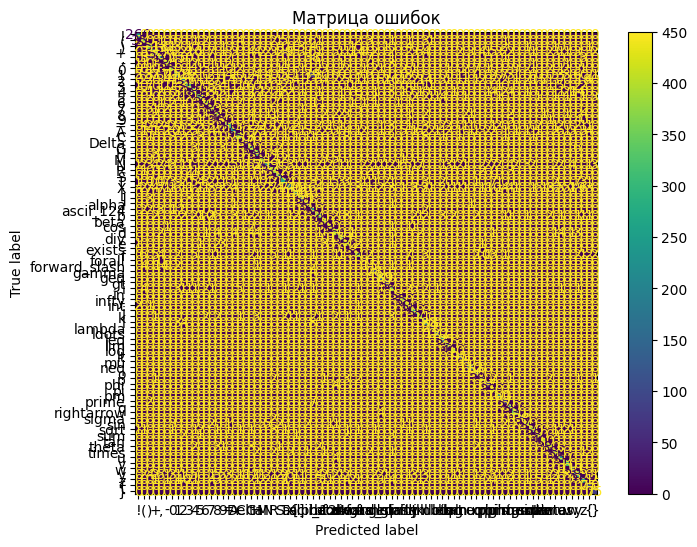

In [56]:
cm = confusion_matrix(y_svm_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_svm_test))
disp.plot(ax=ax)

plt.title("Матрица ошибок")
plt.show()

Сохраним обученную модель

In [53]:
joblib.dump(model_svm, 'svc_model_2000_pca.pkl')

print("Модель сохранена в файл 'multinomial_nb_model.pkl'")

Модель сохранена в файл 'multinomial_nb_model.pkl'


Попробуем обучить модель случайного леса

In [15]:
X_rfc_train, X_rfc_test, y_rfc_train, y_rfc_test = train_test_split(
    X_reduced_pca,
    y_reduced_pca,
    test_size=0.2,
    random_state=42,
    stratify=y_reduced_pca
)

In [ ]:
score = []

for n in range(1, 100):
    print("количество деревьев" + str(n))
    # Используем n случайных деревьев
    model = RandomForestClassifier(n_estimators=n, random_state=40)
    model.fit(X_rfc_train, y_rfc_train)
    test_preds = model.predict(X_rfc_test)
    score.append(mk.f1_score(test_preds, y_rfc_test, average='macro'))

количество деревьев1
количество деревьев2
количество деревьев3
количество деревьев4
количество деревьев5
количество деревьев6
количество деревьев7
количество деревьев8
количество деревьев9
количество деревьев10
количество деревьев11
количество деревьев12
количество деревьев13
количество деревьев14
количество деревьев15
количество деревьев16
количество деревьев17
количество деревьев18
количество деревьев19
количество деревьев20
количество деревьев21
количество деревьев22
количество деревьев23
количество деревьев24
количество деревьев25
количество деревьев26
количество деревьев27
количество деревьев28
количество деревьев29
количество деревьев30
количество деревьев31
количество деревьев32
количество деревьев33
количество деревьев34
количество деревьев35


KeyboardInterrupt: 

In [29]:
len(score)

62

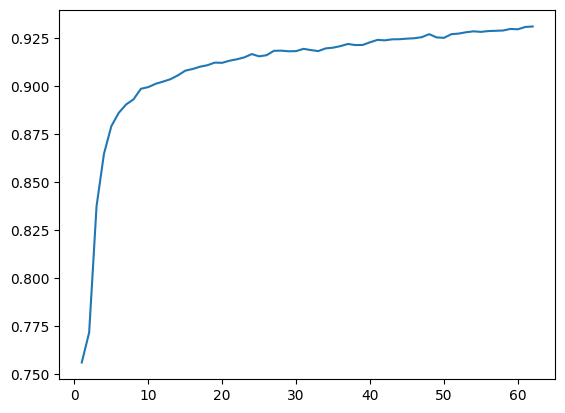

In [31]:
plt.plot(range(1, 63), score)

In [22]:
model_rfc = RandomForestClassifier(n_estimators=100, random_state=42)

model_rfc.fit(X_rfc_train, y_rfc_train)

joblib.dump(model_rfc, 'rfc_model_5000_pca.pkl')

print("Модель сохранена в файл 'rfc_model_5000_pca.pkl'")

Модель сохранена в файл 'rfc_model_5000_pca.pkl'


In [23]:
y_rfc_pred = model_rfc.predict(X_rfc_test)

precision_macro = precision_score(y_rfc_test, y_rfc_pred, average='macro')
recall_macro = recall_score(y_rfc_test, y_rfc_pred, average='macro')
f1_macro = f1_score(y_rfc_test, y_rfc_pred, average='macro')

print(f"Макро-усредненный Precision: {precision_macro:.4f}")
print(f"Макро-усредненный Recall: {recall_macro:.4f}")
print(f"Макро-усредненный F1: {f1_macro:.4f}")

Макро-усредненный Precision: 0.9816
Макро-усредненный Recall: 0.9711
Макро-усредненный F1: 0.9734


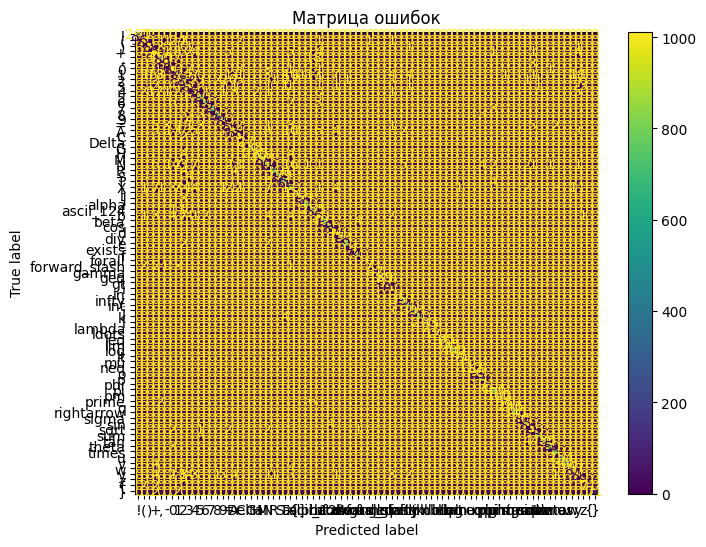

In [24]:
cm = confusion_matrix(y_rfc_test, y_rfc_pred)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_rfc_test))
disp.plot(ax=ax)

plt.title("Матрица ошибок")
plt.show()

Мы получили неплохие результаты, теперь стоит решить проблема получения каждого отдельного символа из текста

In [25]:
def letters_extract(image_file: str, out_size=28) -> List[Any]:
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    img_erode = cv2.erode(thresh, np.ones((3, 3), np.uint8), iterations=1)

    # Get contours
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    output = img.copy()

    letters = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        if hierarchy[0][idx][3] == 0:
            cv2.rectangle(output, (x, y), (x + w, y + h), (70, 0, 0), 1)
            letter_crop = gray[y:y + h, x:x + w]
           
            size_max = max(w, h)
            letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
            if w > h:
              
                y_pos = size_max//2 - h//2
                letter_square[y_pos:y_pos + h, 0:w] = letter_crop
            elif w < h:
                x_pos = size_max//2 - w//2
                letter_square[0:h, x_pos:x_pos + w] = letter_crop
            else:
                letter_square = letter_crop

            letters.append((x, w, cv2.resize(letter_square, (out_size, out_size), interpolation=cv2.INTER_AREA)))

    letters.sort(key=lambda x: x[0], reverse=False)

    return letters

In [29]:
letters = letters_extract('img/test/test1.png', 45)

cv2.imshow("0", letters[0][2])
cv2.imshow("1", letters[1][2])
cv2.imshow("2", letters[2][2])
cv2.imshow("3", letters[3][2])
cv2.imshow("4", letters[4][2])
cv2.waitKey(0)

-1

пробуем, протестить модель на живиых данных

In [30]:
def predict_symbol(img, model):
    img_flatten = img.flatten()

    scaler = joblib.load('scaler_5000_pca.pkl')
    pca = joblib.load('pca_model_5000.pkl')

    img_flatten_scaled = scaler.transform([img_flatten])
    img_reduced = pca.transform(img_flatten_scaled)
    
    return model.predict(img_reduced)

пробуем предсказать

In [50]:
# model = joblib.load('multinomial_nb_2000_model_with_weight.pkl')

letters = letters_extract('img/test/test1.png', 45)
for idx, img_data in enumerate(letters):
    cv2.imshow("4", img_data[2])
    prediction = predict_symbol(img_data[2], model_rfc)
    print(f"Symbol {idx}: {prediction}")
    cv2.waitKey(0)

Symbol 0: ['ascii_124']
Symbol 1: ['+']
Symbol 2: ['1']
Symbol 3: ['-']
Symbol 4: ['+']
Symbol 5: ['2']


In [27]:
# model = joblib.load('multinomial_nb_2000_model_with_weight.pkl')

def get_string_from_image(path_to_image, model, size = 45):
    result = ''
    
    letters = letters_extract(path_to_image, size)
    
    for idx, img_data in enumerate(letters):
        result += predict_symbol(
            img_data[2],
            model
        ).item()
        
    return result

In [46]:
print(get_string_from_image('img/test/test3.png', model_rfc))

3+9=2
